In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('../results.csv')
df.head()

,dataset,split_method,fold,property,model,is_direct,mae,rmse,r2
0,consolidation,scaffold,fold0,absorption,KPGT-Fluor,False,21.566900,33.268852,0.912601
1,consolidation,scaffold,fold0,emission,KPGT-Fluor,False,25.671684,36.180875,0.853202
2,consolidation,scaffold,fold0,quantum_yield,KPGT-Fluor,False,0.140766,0.199598,0.550190
3,consolidation,scaffold,fold0,log_molar_absorptivity,KPGT-Fluor,False,0.154325,0.225147,0.818386
4,cyanine,scaffold,fold0,absorption,KPGT-Fluor,False,17.968945,26.063522,0.942118


In [3]:
consolidation_df = df[df['dataset'] == 'consolidation']

In [4]:
properties = ['absorption', 'emission', 'quantum_yield', 'log_molar_absorptivity']
property_title_map = {
    'absorption': 'Absorption',
    'emission': 'Emission',
    'quantum_yield': 'Quantum Yield',
    'log_molar_absorptivity': 'Log Molar Absorptivity'
}
color_map = plt.get_cmap('Set2')
model_order = ['KPGT-Fluor', 'lightgbm', 'rf', 'gbrt', 'svr']

# 映射字典：将模型名称映射到更具描述性的名称
model_title_map = {
    'KPGT-Fluor': 'KPGT-Fluor',
    'lightgbm': 'LightGBM',
    'rf': 'RF',
    'gbrt': 'GBRT',
    'svr': 'SVR'
}
# model_colors = {model: color_map(i) for i, model in enumerate(model_order)}
model_colors = {model: "tab:blue" for i, model in enumerate(model_order)}

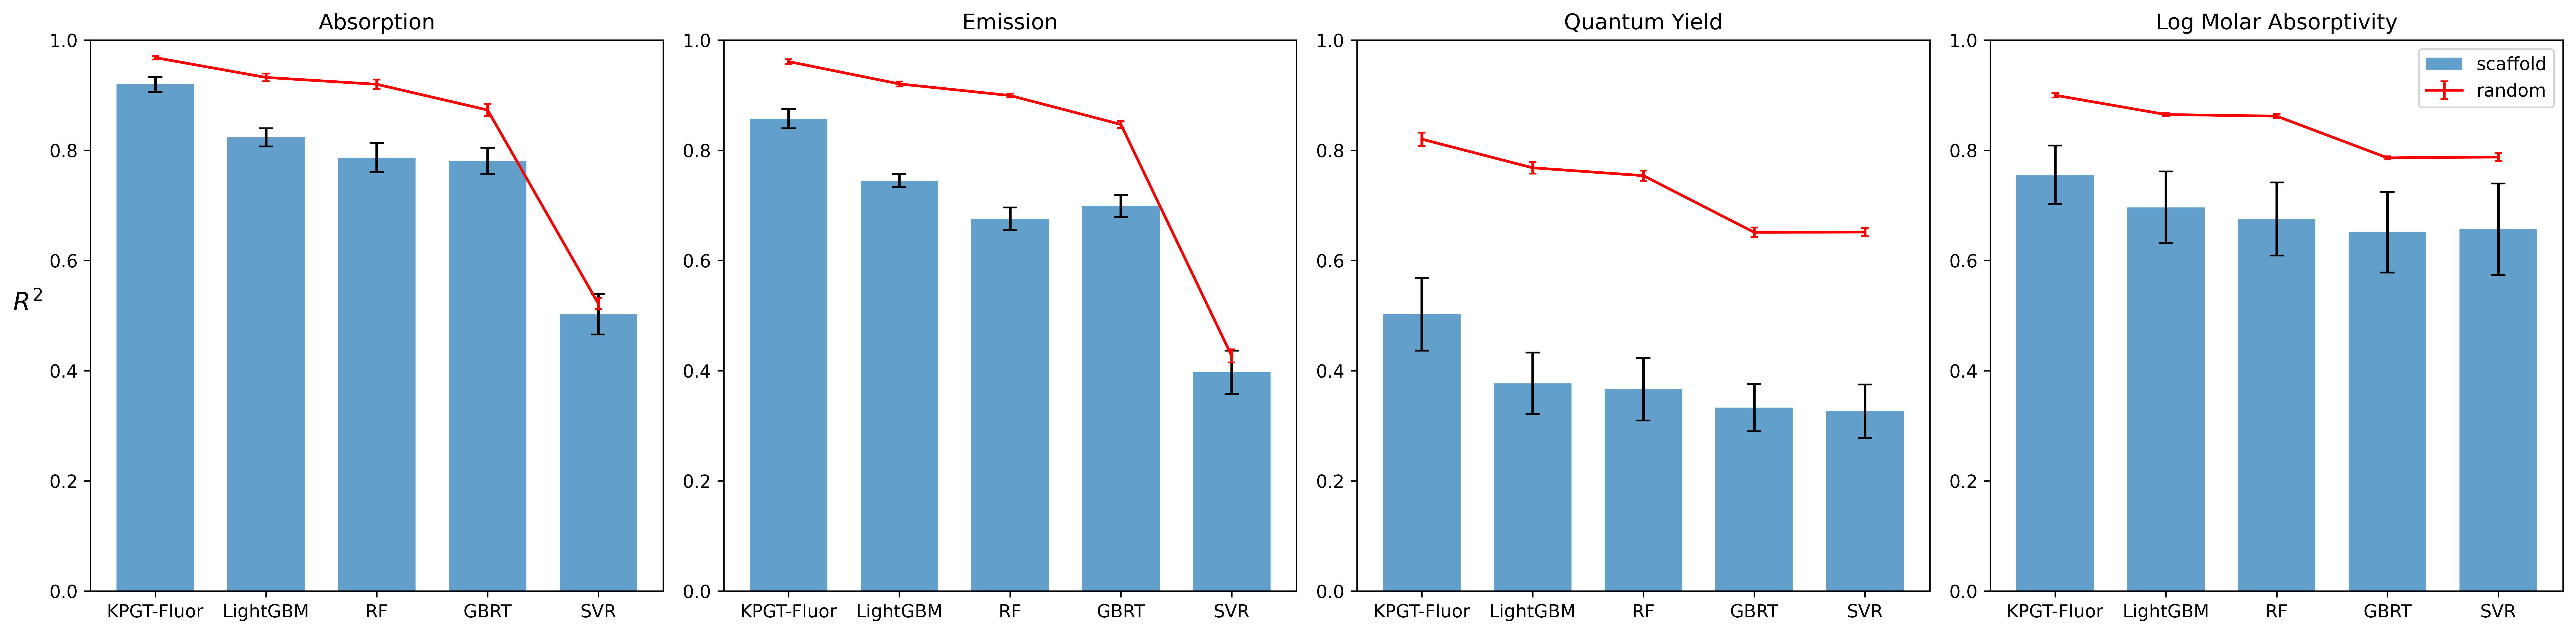

In [5]:
def plot_r2(ax, prop_df, model_order, model_colors, is_first_plot, is_last_plot):
    # Filter the DataFrame for scaffold and random methods
    scaffold_df = prop_df[prop_df['split_method'] == 'scaffold']
    random_df = prop_df[prop_df['split_method'] == 'random']
    
    # Plot Scaffold Data (bar plot)
    if not scaffold_df.empty:
        scaffold_grouped = scaffold_df.groupby('model')['r2']
        scaffold_means = scaffold_grouped.mean().reindex(model_order)
        scaffold_stds = scaffold_grouped.std().reindex(model_order)

        # Adjust the width of the bars (set the width to a smaller value)
        ax.bar(
            model_order,
            scaffold_means,
            yerr=scaffold_stds,
            capsize=4,
            alpha=0.7,
            label='scaffold',
            color=[model_colors[m] for m in model_order],
            width=0.7  # Narrower bars
        )
    
    # Plot Random Data (error bars)
    if not random_df.empty:
        random_grouped = random_df.groupby('model')['r2']
        random_means = random_grouped.mean().reindex(model_order)
        random_stds = random_grouped.std().reindex(model_order)

        ax.errorbar(
            x=range(len(model_order)),
            y=random_means,
            yerr=random_stds,
            capsize=2,
            label='random',
            color='red'
        )

    # Set plot labels and titles using the title map
    prop_title = property_title_map.get(prop_df['property'].iloc[0], prop_df['property'].iloc[0])
    ax.set_title(prop_title)
    ax.set_xlabel('')

    # Set Y axis label only for the first plot
    if is_first_plot:
        ax.set_ylabel('$R^2$', rotation=0, ha="right", fontsize=14)



    # Set X ticks and labels
    ax.set_xticks(range(len(model_order)))
    ax.set_xticklabels([model_title_map.get(m, m) for m in model_order])  # Apply model name mapping
    ax.set_ylim(0, 1)

    # Show legend only on the last plot
    if is_last_plot:
        ax.legend()

def plot_r2_for_all_properties(consolidation_df, properties, model_order, model_colors):
    fig, axes = plt.subplots(1, len(properties), figsize=(20, 5), sharey=False, dpi=600)

    # Iterate over each property and plot
    for i, (ax, prop) in enumerate(zip(axes, properties)):
        prop_df = consolidation_df[consolidation_df['property'] == prop]
        is_first_plot = (i == 0)  # Set True for the first plot
        is_last_plot = (i == len(properties) - 1)  # Set True for the last plot
        plot_r2(ax, prop_df, model_order, model_colors, is_first_plot, is_last_plot)

    plt.tight_layout()
    plt.show()

# Example usage
plot_r2_for_all_properties(consolidation_df, properties, model_order, model_colors)

In [6]:
cyanine_df = df[df['dataset'] == 'cyanine']
xanthene_df = df[df['dataset'] == 'xanthene']

In [7]:
def plot_r2(ax, prop_df, model_order, model_colors, is_first_plot, is_last_plot):
    x = np.arange(len(model_order))
    total_bar_width = 0.7
    bar_width = total_bar_width / 2
    point_offset = 0.15  # Random 点的左右偏移

    # === Scaffold 柱状图 ===
    scaffold_df = prop_df[prop_df['split_method'] == 'scaffold']
    if not scaffold_df.empty:
        for is_direct_val in [False, True]:
            df = scaffold_df[scaffold_df['is_direct'] == is_direct_val]
            grouped = df.groupby('model')['mae']
            means = grouped.mean().reindex(model_order)
            stds = grouped.std().reindex(model_order)

            offset = -bar_width / 2 if not is_direct_val else bar_width / 2
            label = 'Transfer Learning (Scaffold)' if not is_direct_val else 'Direct (Scaffold)'
            alpha = 0.7 if not is_direct_val else 0.4

            ax.bar(
                x + offset,
                means,
                yerr=stds,
                width=bar_width,
                label=label,
                color=[model_colors.get(m, 'gray') for m in model_order],
                alpha=alpha,
                capsize=4
            )

    # === Random 折线图（分 direct/indirect）===
    random_df = prop_df[prop_df['split_method'] == 'random']
    if not random_df.empty:
        for is_direct_val, marker, color, label in [
            (False, 'o', 'blue', 'Transfer Learning (Random)'),
            (True,  's', 'red',  'Direct (Random)')
        ]:
            df = random_df[random_df['is_direct'] == is_direct_val]
            grouped = df.groupby('model')['mae']
            means = grouped.mean().reindex(model_order)
            stds = grouped.std().reindex(model_order)

            offset = -point_offset if not is_direct_val else point_offset

            ax.errorbar(
                x + offset,
                means,
                yerr=stds,
                # fmt=marker + '-',
                color=color,
                label=label,
                capsize=4,
                markersize=5,
                linewidth=1.2
            )

    # === Plot 样式设置 ===
    prop_title = property_title_map.get(prop_df['property'].iloc[0], prop_df['property'].iloc[0])
    ax.set_title(prop_title, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([model_title_map.get(m, m) for m in model_order])

    if is_first_plot:
        ax.set_ylabel('MAE', fontsize=12)
        ax.legend(fontsize=10)

    # if is_last_plot:
    #     ax.legend(frameon=False, fontsize=10)

def plot_r2_for_all_properties(consolidation_df, properties, model_order, model_colors):
    fig, axes = plt.subplots(1, len(properties), figsize=(5 * len(properties), 5), sharey=False, dpi=600)

    if len(properties) == 1:
        axes = [axes]

    for i, (ax, prop) in enumerate(zip(axes, properties)):
        prop_df = consolidation_df[consolidation_df['property'] == prop]
        is_first_plot = (i == 0)
        is_last_plot = (i == len(properties) - 1)
        plot_r2(ax, prop_df, model_order, model_colors, is_first_plot, is_last_plot)

    plt.tight_layout()
    plt.show()

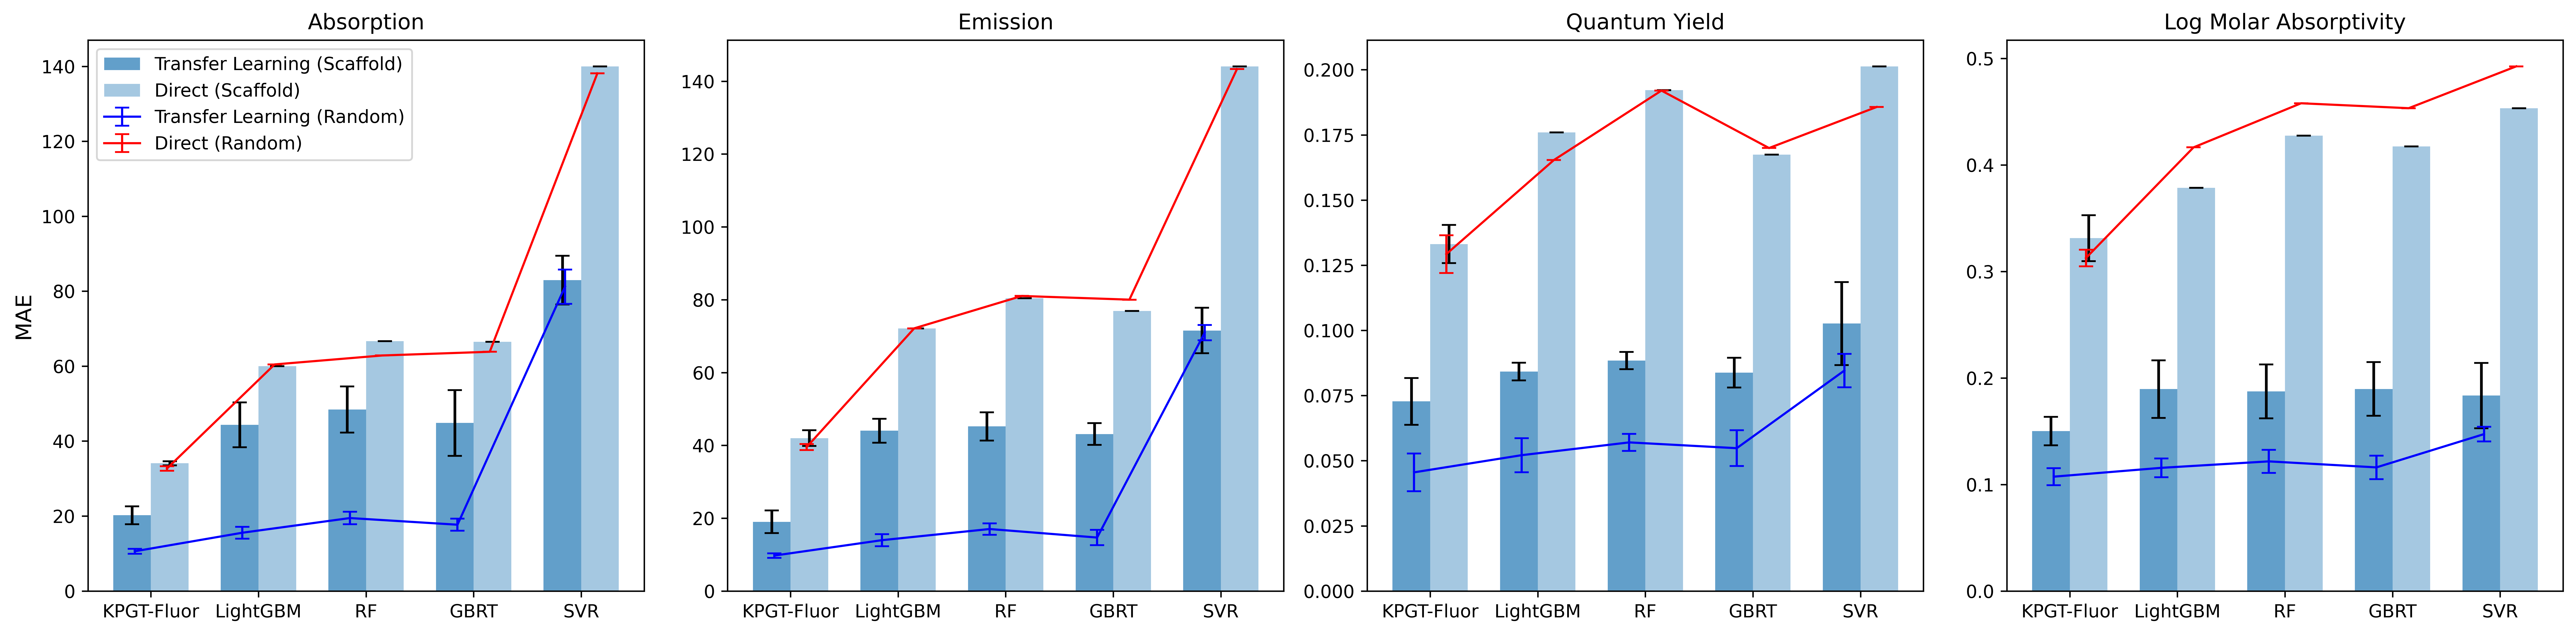

In [8]:
plot_r2_for_all_properties(cyanine_df, properties, model_order, model_colors)

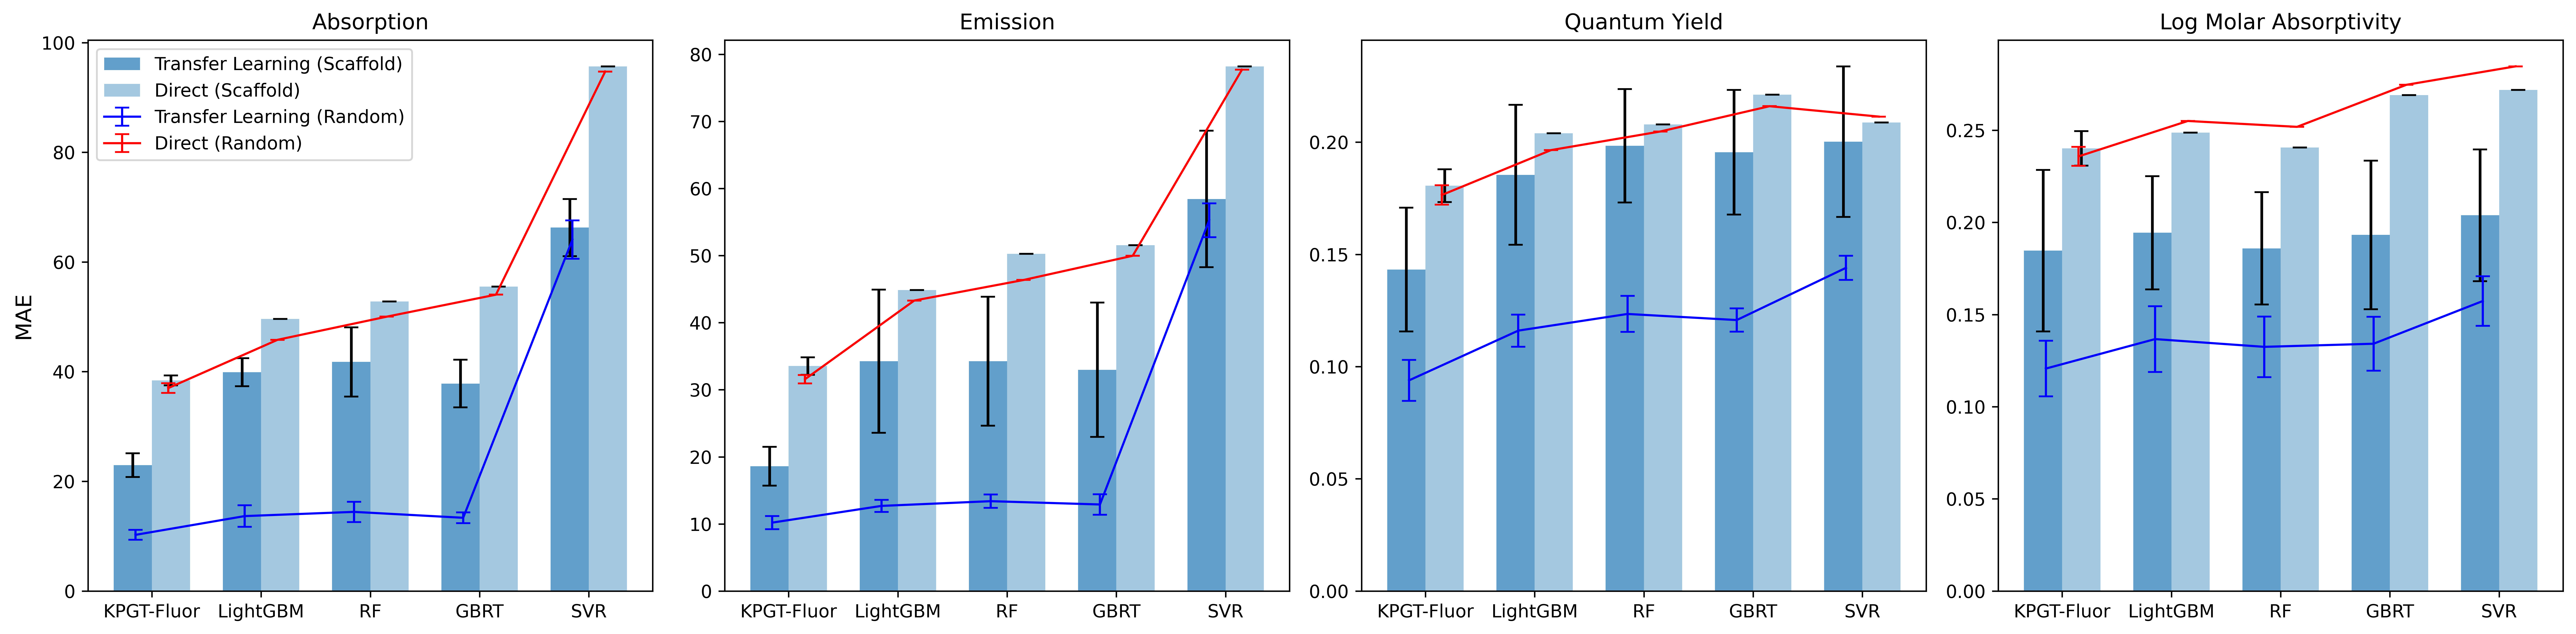

In [9]:
plot_r2_for_all_properties(xanthene_df, properties, model_order, model_colors)